In [1]:
.libPaths("/no_backup/jferrer/jmidgley/R_libs")
library(dplyr)
library(Seurat)
library(patchwork)
library(repr)
library(ggplot2)
library(ggrepel)
library(tidyr)
library(tibble)
library(showtext)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.7.3 but the current
version is 1.7.4; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: sysfonts

Loading required package: showtextdb



In [2]:
options(repr.plot.width = 10, repr.plot.height = 8)

In [3]:
font_add("Latin Modern Math", "../data_raw/fonts/LatinmodernmathRegular.otf")
showtext_auto()
theme_set(theme_minimal(base_family = "Latin Modern Math"))

In [4]:
vasa_seq_all <- readRDS("../data_processed/VASAseq/VASAseq_all_with_CellType.RDS")
vasa_seq_all

An object of class Seurat 
20551 features across 14881 samples within 1 assay 
Active assay: RNA (20551 features, 2000 variable features)
 3 layers present: scale.data, data, counts
 3 dimensional reductions calculated: pca, harmony, umap

In [5]:
head(vasa_seq_all@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters,Donor,Disease,CellType
,<chr>,<dbl>,<int>,<dbl>,<fct>,<fct>,<chr>,<chr>,<fct>
HUB-NG-v005_HUB.NG.v005_369,HUB.NG.v005,66385,6748,0,3,3,GPRL,ND,Beta
HUB-NG-v005_HUB.NG.v005_2,HUB.NG.v005,9378,2430,0,12,12,GPRL,ND,Unknown
HUB-NG-v005_HUB.NG.v005_336,HUB.NG.v005,86150,7784,0,6,6,GPRL,ND,Ductal
HUB-NG-v005_HUB.NG.v005_48,HUB.NG.v005,46151,7080,0,3,3,GPRL,ND,Beta
HUB-NG-v005_HUB.NG.v005_290,HUB.NG.v005,15393,3890,0,1,1,GPRL,ND,Ductal


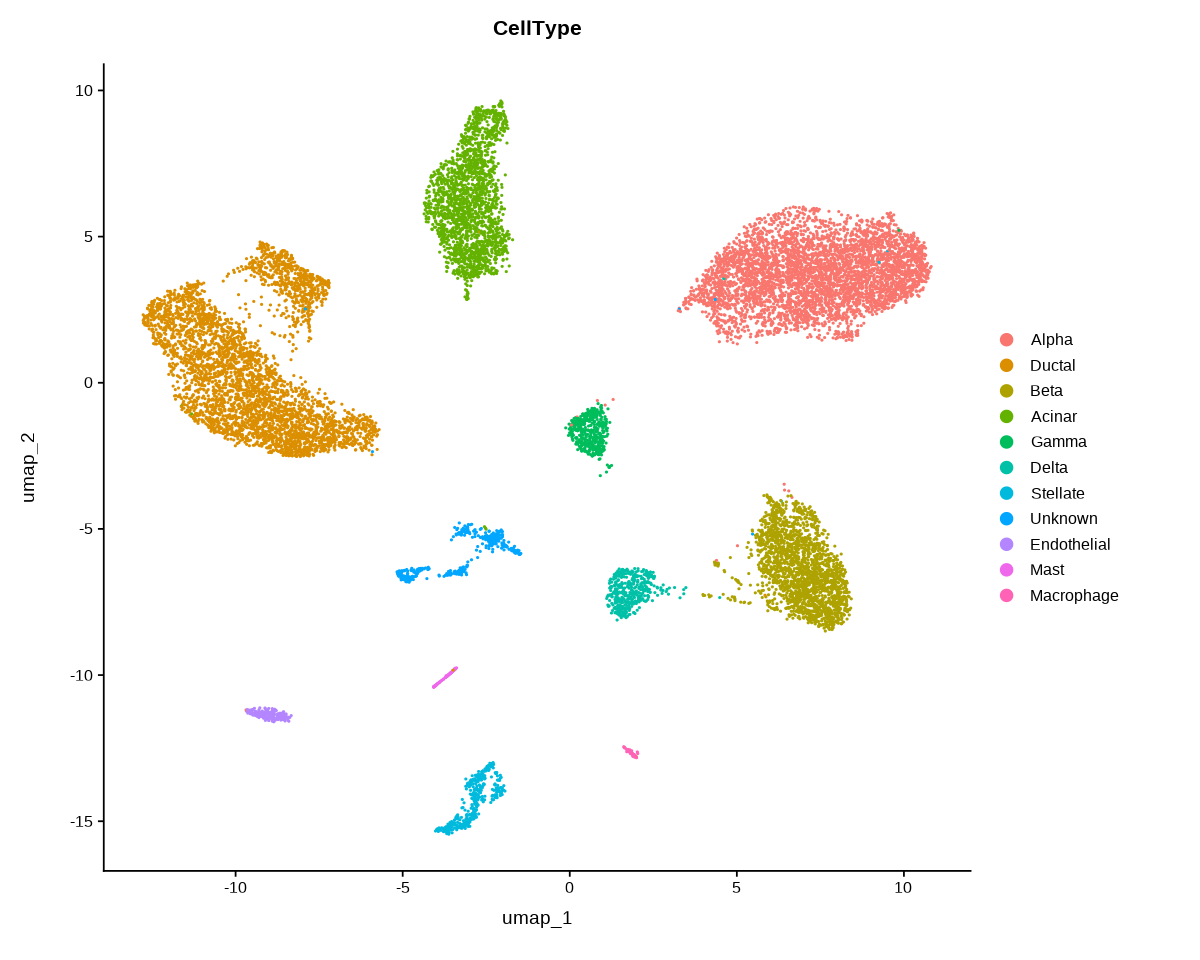

In [6]:
DimPlot(vasa_seq_all, reduction = "umap", group.by = "CellType")

In [7]:
vasa_seq_all <- subset(vasa_seq_all, subset = Disease != "rT2D")

In [8]:
table(vasa_seq_all@meta.data$Disease)


  ND  T2D 
5917 7541 

In [9]:
Idents(vasa_seq_all) <- "Disease"
levels(Idents(vasa_seq_all))

[1] "ND"  "T2D"

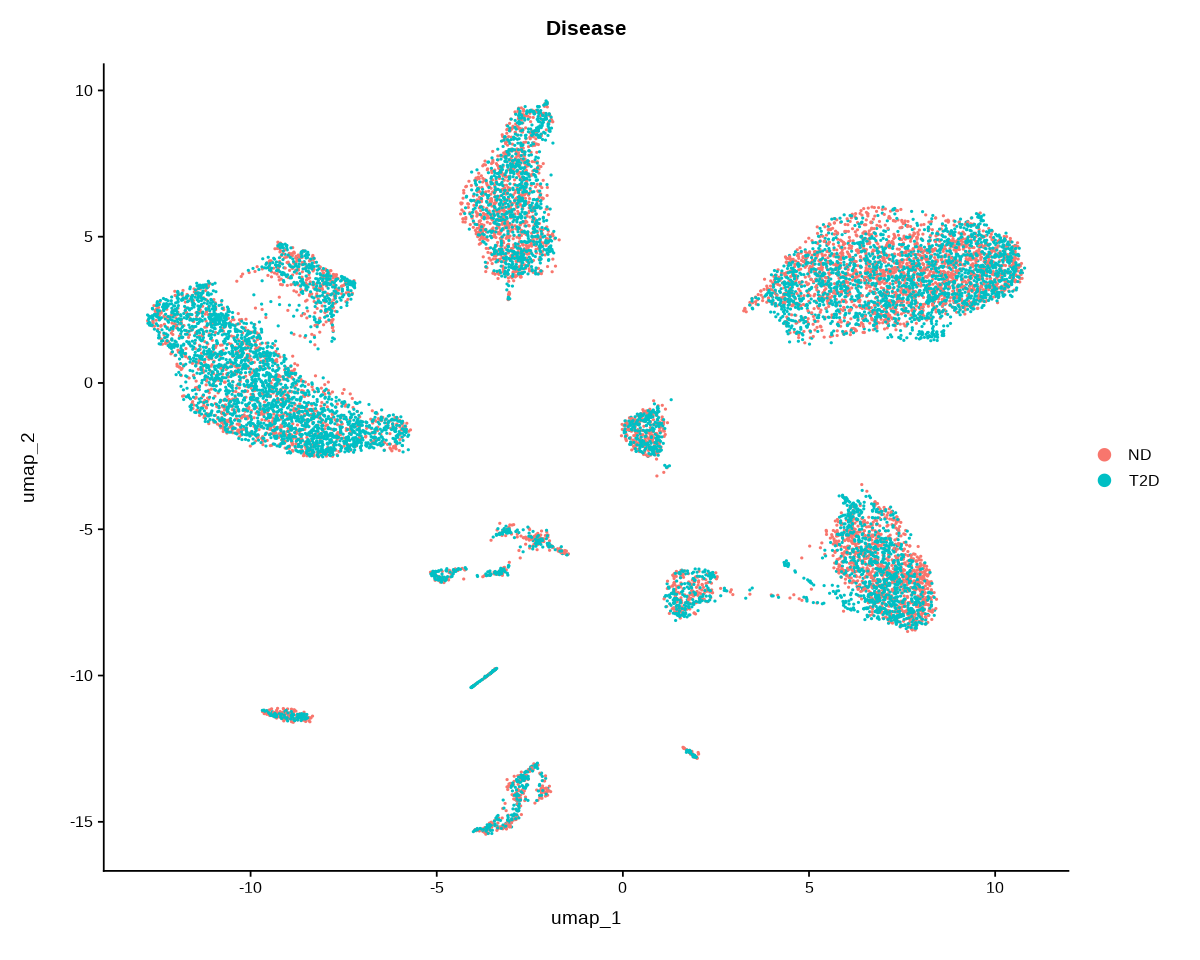

In [10]:
DimPlot(vasa_seq_all, reduction = "umap", group.by = "Disease")

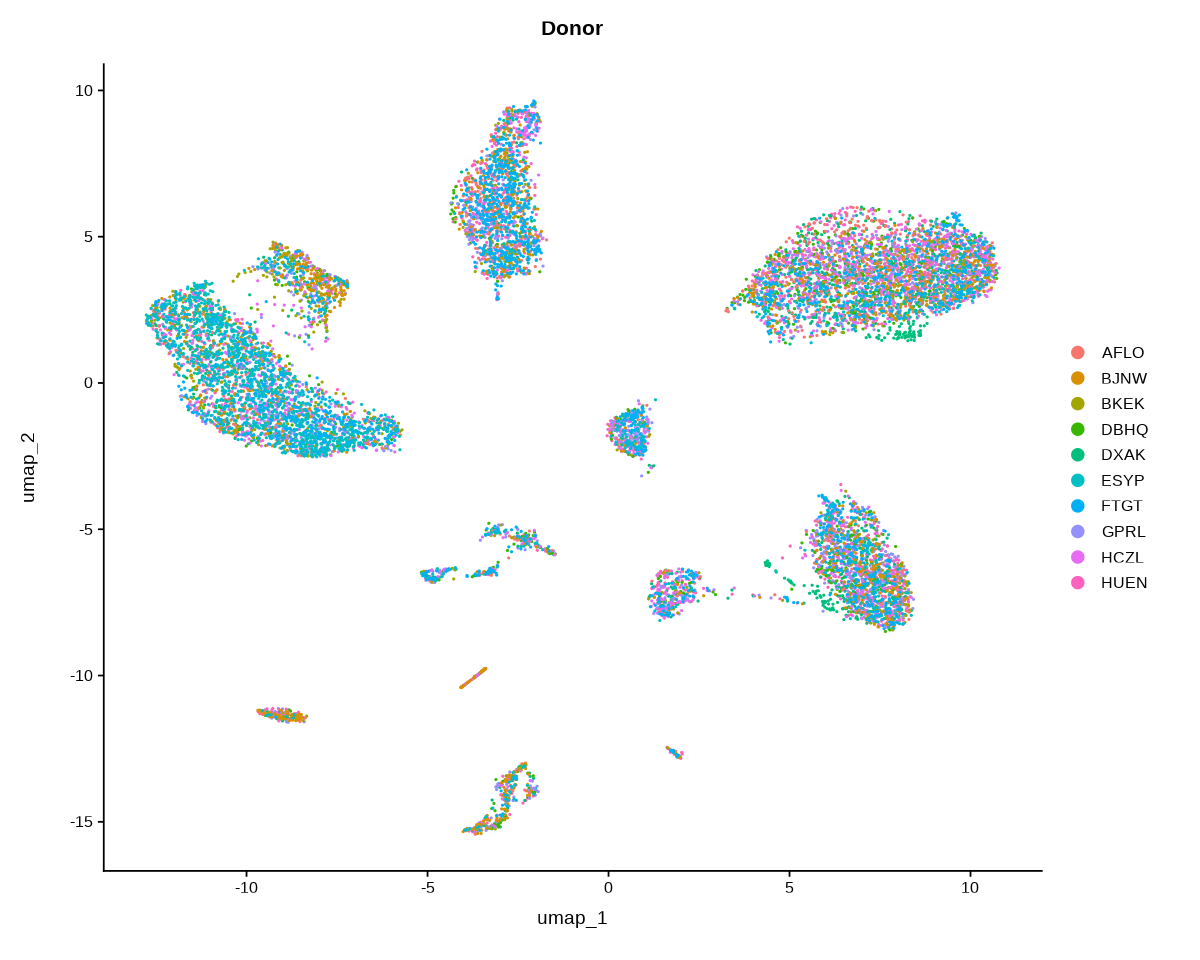

In [11]:
DimPlot(vasa_seq_all, reduction = "umap", group.by = "Donor")

In [12]:
# Subset to only alpha
vasa_seq_alpha <- subset(vasa_seq_all, subset = CellType == "Alpha")

In [13]:
table(vasa_seq_alpha@meta.data$Disease)


  ND  T2D 
1834 2088 

In [14]:
# Subset to only beta
vasa_seq_beta <- subset(vasa_seq_all, subset = CellType == "Beta")

In [15]:
table(vasa_seq_beta@meta.data$Disease)


 ND T2D 
935 991 

In [16]:
# get markers
markers_df_alpha <- FindMarkers(vasa_seq_alpha, ident.1 = "T2D", ident.2 = "ND")
markers_df_beta <- FindMarkers(vasa_seq_beta, ident.1 = "T2D", ident.2 = "ND")

In [17]:
# Add significance category
markers_df_alpha$significance <- "Not Significant"
markers_df_alpha$significance[markers_df_alpha$avg_log2FC > 1.5 & markers_df_alpha$p_val_adj < 0.01] <- "Upregulated in T2D"
markers_df_alpha$significance[markers_df_alpha$avg_log2FC < -1.5 & markers_df_alpha$p_val_adj < 0.01] <- "Upregulated in ND"


markers_df_beta$significance <- "Not Significant"
markers_df_beta$significance[markers_df_beta$avg_log2FC > 1.5 & markers_df_beta$p_val_adj < 0.01] <- "Upregulated in T2D"
markers_df_beta$significance[markers_df_beta$avg_log2FC < -1.5 & markers_df_beta$p_val_adj < 0.01] <- "Upregulated in ND"

In [18]:
# Add gene names as row
markers_df_alpha$gene_name <- rownames(markers_df_alpha)
markers_df_alpha$gene_name <- gsub("-", "_", markers_df_alpha$gene_name)
markers_df_alpha$gene_name <- gsub("\\.", "-", markers_df_alpha$gene_name)

rownames(markers_df_alpha) <- markers_df_alpha$gene_name



markers_df_beta$gene_name <- rownames(markers_df_beta)
markers_df_beta$gene_name <- gsub("-", "_", markers_df_beta$gene_name)
markers_df_beta$gene_name <- gsub("\\.", "-", markers_df_beta$gene_name)

rownames(markers_df_beta) <- markers_df_beta$gene_name

In [19]:
unmapped_gene_name_map <- read.csv("../data_processed/unmapped_gene_name_map.csv")

In [20]:
idx <- match(markers_df_alpha$gene_name, unmapped_gene_name_map$Gene.name)
repl <- unmapped_gene_name_map$updated_gene_name[idx]
markers_df_alpha$gene_name <- ifelse(!is.na(repl), repl, markers_df_alpha$gene_name)
head(markers_df_alpha)


idx <- match(markers_df_beta$gene_name, unmapped_gene_name_map$Gene.name)
repl <- unmapped_gene_name_map$updated_gene_name[idx]
markers_df_beta$gene_name <- ifelse(!is.na(repl), repl, markers_df_beta$gene_name)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,significance,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
RNU4-2,9.359530e-253,1.3836068,0.950,0.567,1.923477e-248,Not Significant,RNU4-2
RNU4-1,1.540285e-198,1.2757772,0.910,0.547,3.165439e-194,Not Significant,RNU4-1
CTRB2,7.040255e-169,-2.1537536,0.649,0.869,1.446843e-164,Upregulated in ND,CTRB2
ENSG00000303858,1.797961e-157,0.7345762,0.998,0.983,3.694990e-153,Not Significant,ENSG00000303858
RPPH1,3.686473e-146,0.7715926,1.000,0.989,7.576071e-142,Not Significant,RPPH1
SNHG3,9.591981e-137,0.8858513,0.973,0.810,1.971248e-132,Not Significant,SNHG3


In [21]:
beta_unannotated_ND <- subset(markers_df_beta, grepl("^HIT", gene_name) & significance == "Upregulated in ND")
beta_unannotated_T2D <- subset(markers_df_beta, grepl("^HIT", gene_name) & significance == "Upregulated in T2D")

In [22]:
alpha_unannotated_ND <- subset(markers_df_alpha, grepl("^HIT", gene_name) & significance == "Upregulated in ND")
alpha_unannotated_T2D <- subset(markers_df_alpha, grepl("^HIT", gene_name) & significance == "Upregulated in T2D")

In [23]:
intersect(beta_unannotated_ND$gene_name,
          alpha_unannotated_ND$gene_name)

[1] "HIT68312-NC" "HIT45209-NC"

In [24]:
intersect(beta_unannotated_T2D$gene_name,
          alpha_unannotated_T2D$gene_name)

[1] "HIT58963-NC" "HIT31161-NC" "HIT12233-NC" "HIT69971-NC"

In [25]:
alpha_unannotated_T2D

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,significance,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Peak_58963,1.905027e-49,2.616550,0.189,0.038,3.915021e-45,Upregulated in T2D,HIT58963-NC
Peak_31161,6.067768e-43,4.771108,0.114,0.007,1.246987e-38,Upregulated in T2D,HIT31161-NC
Peak_12233,1.778630e-21,2.517103,0.082,0.015,3.655262e-17,Upregulated in T2D,HIT12233-NC
Peak_10277,6.220499e-20,1.758986,0.080,0.016,1.278375e-15,Upregulated in T2D,HIT10277-NC
Peak_43811,5.291919e-19,1.574651,0.234,0.135,1.087542e-14,Upregulated in T2D,HIT43811-NC
Peak_69971,1.701711e-18,4.272793,0.045,0.002,3.497185e-14,Upregulated in T2D,HIT69971-NC
Peak_62480,3.848788e-13,1.649193,0.048,0.009,7.909645e-09,Upregulated in T2D,HIT62480-NC
Peak_34301,4.156878e-13,1.850319,0.064,0.017,8.542801e-09,Upregulated in T2D,HIT34301-PC
Peak_34198,7.411599e-09,2.157014,0.037,0.009,1.523158e-04,Upregulated in T2D,HIT34198-NC


In [26]:
# Alpha
alpha_plot_df <- markers_df_alpha
alpha_plot_df$annotation_status <- "Annotated"
alpha_plot_df$annotation_status[alpha_plot_df$gene_name %in% alpha_unannotated_T2D$gene_name] <- "Unannotated"
alpha_plot_df$annotation_status[alpha_plot_df$gene_name %in% alpha_unannotated_ND$gene_name]  <- "Unannotated"
alpha_plot_df$cell_type <- "Alpha"

# Beta
beta_plot_df <- markers_df_beta
beta_plot_df$annotation_status <- "Annotated"
beta_plot_df$annotation_status[beta_plot_df$gene_name %in% beta_unannotated_T2D$gene_name] <- "Unannotated"
beta_plot_df$annotation_status[beta_plot_df$gene_name %in% beta_unannotated_ND$gene_name]  <- "Unannotated"
beta_plot_df$cell_type <- "Beta"

# Combine
plot_df <- rbind(alpha_plot_df, beta_plot_df)


In [27]:
options(repr.plot.width = 12, repr.plot.height = 5)

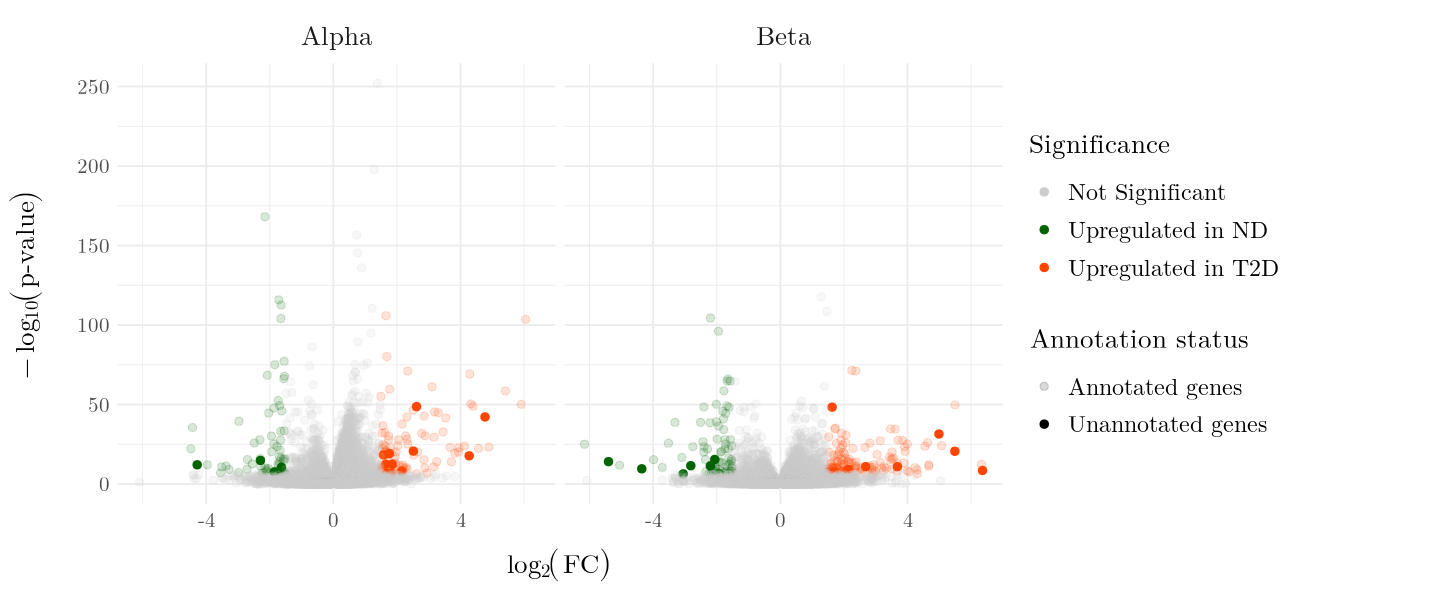

In [28]:
p <- ggplot(plot_df, aes(x = avg_log2FC, y = -log10(p_val))) +
  geom_point(
    aes(color = significance, alpha = annotation_status),
    size = 2,
    show.legend = TRUE
  ) +
  facet_wrap(~ cell_type, nrow = 1) +
  scale_color_manual(
    name = "Significance", 
    values = c(
      "Upregulated in T2D" = "orangered",
      "Upregulated in ND"  = "darkgreen",
      "Not Significant"    = "grey80"
    )
  ) +
  scale_alpha_manual(
    name = "Annotation status",
    values = c("Annotated" = 0.15, "Unannotated" = 1),
    labels = c("Annotated genes", "Unannotated genes")
  ) +
  guides(
    color = guide_legend(order = 1),
    alpha = guide_legend(order = 2)
  ) +
  coord_cartesian(clip = "off") +
  labs(
    x = expression(log[2](FC)),
    y = expression(-log[10]("p-value"))
  ) +
  theme_minimal() +
  theme(
    text = element_text(family = "Latin Modern Math"),
    axis.title = element_text(size = 20), # axis labels
    axis.text  = element_text(size = 16),  # tick marks
    legend.title = element_text(size = 20, face = "bold"),
    legend.text  = element_text(size = 18),
    legend.spacing.y = unit(0.3, "cm"),
    legend.key.height = unit(0.8, "cm"),
    strip.text = element_text(size = 20, face = "bold") # alpha and beta headings
  )
p

In [29]:
ggsave("figures/volcano_t2d_nd_gene.pdf", p, width = 12, height = 5, dpi = 300)